In [6]:
import glob
import os
import xarray as xr
import numpy as np
import cmocean
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import path, colors
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy import stats
import pandas as pd
from datetime import datetime, timedelta
import numba as nb

In [7]:
import matplotlib as mpl
from matplotlib import rc

font = {'family' : 'Latin Modern Math', #['serif', 'sans-serif', 'cursive', 'fantasy', 'monospace']
        'style'  : 'normal', #['normal', 'italic', 'oblique']
        'weight' : 'normal', #['light', 'normal', 'medium', 'semibold', 'bold', 'heavy', 'black']
        'size'   : 8}

mpl.rc('font', **font)

In [8]:
df = pd.read_csv('../data/process/coasts_uniform.csv')

In [33]:
df.head()

,longitude,latitude,country id
0,-62.410036,16.852480,0
1,-62.363943,16.844647,0
2,-62.381441,16.909294,0
3,-62.392107,16.888089,0
4,-62.427517,16.896646,0


In [71]:
np.sum(df['country id'] == c_id1)

505

In [72]:
np.sum(df['country id'] == c_id2)

145

In [47]:
c_id1 = 22
c_id2 = 27
c_id = f"{c_id1}_{c_id2}"
#traj_index = np.where(df['country id'] == c_id)[0]
traj_index = np.where(np.logical_or(df['country id'] == c_id1, df['country id'] == c_id2))[0]
origin_date = datetime(2010,1,1)

caribbean_countries = [ # countries
    'Antigua and Barbuda', 'Bahamas', 'Barbados',
    'Cuba', 'Dominica', 'Dominican Republic',
    'Grenada', 'Haiti', 'Jamaica', 'Saint Kitts and Nevis',
    'Saint Lucia', 'Saint Vincent and the Grenadines',
    'Trinidad and Tobago',
    # dependant territory
    'Anguilla', 'Aruba',
    'Bonaire, Sint Eustatius and Saba',
    'British Virgin Islands', 'Cayman Islands',
    'Curaçao', 'Guadeloupe', 'Martinique',
    'Montserrat', 'Puerto Rico', 'Saint-Barthélemy',
    'Saint-Martin', 'Sint Maarten',
    'Turks and Caicos Islands', 'Virgin Islands, U.S.',
    # other countries
    'Mexico', 'United States', 'Venezuela', 'Belize', 'Colombia',
    'Costa Rica', 'Guatemala', 'Guyana', 'Honduras', 'Nicaragua', 'Panama',
    'Suriname']

In [48]:
files = sorted(glob.glob('../data/output/cm_uniform/cm_uniform_*.nc'))

In [49]:
# first file for longuest trajectories
with xr.open_dataset('../data/output/cm_uniform/cm_uniform_2010-01-01.nc') as ds:
    nb_obs = ds.dims['obs']

nb_traj = len(traj_index) * len(files)

In [50]:
lon = np.full((nb_traj, nb_obs), np.nan)
lat = np.full((nb_traj, nb_obs), np.nan)

In [51]:
for i, f in enumerate(files):
    r = slice(i*len(traj_index), (i+1)*len(traj_index))    
    ds = xr.open_dataset(f)
    offset = nb_obs - ds.dims['obs']
    lon[r, offset:] = ds.lon[traj_index]
    lat[r, offset:] = ds.lat[traj_index]
    ds.close()

In [52]:
@nb.njit
def haversine(lon, lat):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon, lat = map(np.radians, [lon, lat])

    dlon = lon[:, 1:] - lon[:, :-1]
    dlat = lat[:, 1:] - lat[:, :-1]

    a = np.sin(dlat/2.0)**2 + np.cos(lat[:, :-1]) * np.cos(lat[:, 1:]) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    dist = 6371000 * c # [m]
    return dist

def identify_beaching(distance, eps, period):
    '''
    From a list of traveled distance of a trajectory, find beaching event, which is 
    defined when a trajectory traveled distance is less than a minimal distance over a continous period of days.
    
    Args:
        distance[array]: traveled distance per day [m]
        eps: distance minimal for a particle to be considered moving
        period: number of continous days the criteria has to hold
        
    Return:
        id: index to the position/time where the trajectory is considered beached
    '''
    
    low_dist = (distance < eps) * 1
    low_dist = np.insert(low_dist, [0, len(low_dist)], [0, 0]) # boundary conditions
    change_mvt = np.diff(low_dist)

    # find ranges of low displacement
    start = np.where(change_mvt == 1)[0]
    end = np.where(change_mvt == -1)[0]
    assert(len(start) == len(end))
    length = (end - start)
    
    beachings = np.where(length >= period)[0]
    if len(beachings):
        return start[beachings[0]] + period  # first beaching criteria
    else:
        return -99999 # end of the release

In [53]:
# distance at each timestep for each trajectory
d = haversine(lon, lat)

# identify beaching
# a drifters is considered beach if it travels less than 3km for 30 days in a row
# which is similar to the < 100km in the past month Xiaobiao used
threshold_distance = 3000 # [m]
period = 30  # [days]
beached_days = 90  # [days]

b_idx = np.zeros(nb_traj, dtype=int)
b_time = np.zeros(nb_traj, dtype='datetime64[ns]')
for i in range(0, nb_traj):
    b_idx[i] = identify_beaching(d[i], threshold_distance, period)

# replace values after beaching with previous value
# for beached_days long
for i in np.where(b_idx != -99999)[0]:
    j = b_idx[i]
    lon[i,j+1:] = np.nan
    lat[i,j+1:] = np.nan
    lon[i,j+1:min(j+1+beached_days, nb_obs)] = lon[i,j]
    lat[i,j+1:min(j+1+beached_days, nb_obs)] = lat[i,j]

In [54]:
def trajectories(ax, t0, length):
    # smaller length at initial time
    if length > t0:
        length = t0
    
    time_r = range(t0-length, t0+1)
    keep = np.any(~np.isnan(lon[:, time_r]), 1)
    traj = list(zip(lon[keep][:,time_r], lat[keep][:,time_r]))
    
    s, v = [], []
    for x,y in traj:
        pts = np.array([x, y]).T.reshape(-1, 1, 2)
        s.extend(np.concatenate([pts[:-1], pts[1:]], axis=1))
        v.extend(np.arange(0, len(x))/len(x))
    
    v = np.array(v).flatten()
    
    lc = LineCollection(s, cmap=cmocean.cm.ice_r, transform=ccrs.PlateCarree(), alpha=1.0)
    lc.set_array(v) # color per segments/lines
    lc.set_linewidth(0.25) # size of lines
    ax.add_collection(lc)
    
    # add tip
    ax.scatter(lon[keep][:,t0], lat[keep][:,t0], s=0.2, linewidth=0.5, c='k', marker='o', facecolors='fill', zorder=2)
    
    # add red tip if beached
    beached = np.logical_and.reduce((b_idx > -99999, b_idx < t0, b_idx+beached_days >= t0, keep))
    ax.scatter(lon[beached][:,t0], lat[beached][:,t0], s=0.1, linewidth=0.5, c='r', marker='o', facecolors='fill', zorder=2)
    
    return s, v

0
CPU times: user 44.5 ms, sys: 1.81 ms, total: 46.3 ms
Wall time: 45.7 ms


Text(0.5, 1.0, 'Puerto Rico & US Virgin Islands (2010-01-01)')

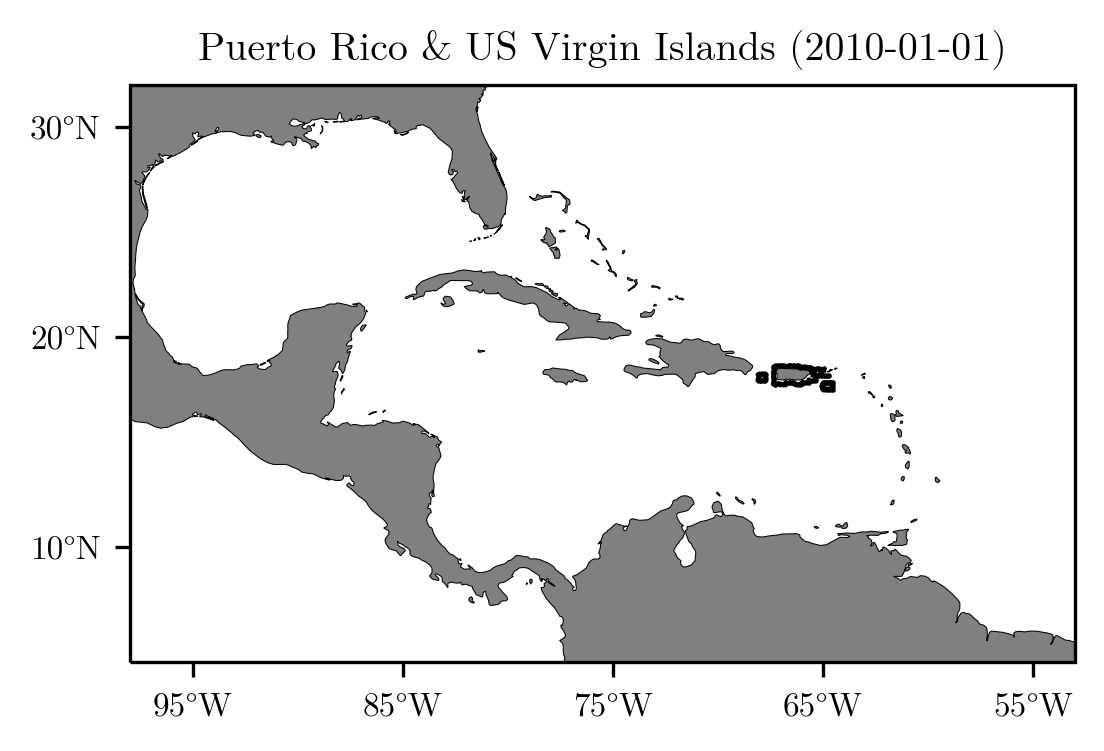

In [75]:
%%time
fig = plt.figure(dpi=300, figsize=(5,2.5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), aspect='equal')

t0 = 0
traj_length = 10  # index/days because daily output
s, v = trajectories(ax, t0, traj_length)
print(len(s))
ax.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)

ax.set_xlim([-98, -53])
ax.set_ylim([4.5, 32])
ax.set_xticks([-95, -85,-75,-65,-55], crs=ccrs.PlateCarree())
ax.set_yticks([10,20,30], crs=ccrs.PlateCarree())

ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_title(f"Puerto Rico & US Virgin Islands {(origin_date+timedelta(days=t0)).strftime('(%Y-%m-%d)')}")
#ax.set_title(f"{caribbean_countries[c_id]} {(origin_date+timedelta(days=t0)).strftime('(%Y-%m-%d)')}")
#fig.savefig(f'cm_uniform_{t0:04d}.png', bbox_inches='tight', format='png', dpi=600)

In [57]:
# chose 3 countries as example
cids = [22, 27]
for c_id in cids:
    print(caribbean_countries[c_id])

Puerto Rico
Virgin Islands, U.S.


In [ ]:
#for c_id in np.arange(0, 40):
c_id1 = 22
c_id2 = 27
c_id = f"{c_id1}_{c_id2}"

os.makedirs(f'countries/{c_id}', exist_ok=f'countries/{c_id}')
# get id of country trajectories
#traj_index = np.where(df['country id'] == c_id)[0]
traj_index = np.where(np.logical_or(df['country id'] == c_id1, df['country id'] == c_id2))[0]

nb_traj = len(traj_index) * len(files)
lon = np.full((nb_traj, nb_obs), np.nan)
lat = np.full((nb_traj, nb_obs), np.nan)

# loop the files to read all trajectories
for i, f in enumerate(files):
    r = slice(i*len(traj_index), (i+1)*len(traj_index))    
    ds = xr.open_dataset(f)
    offset = nb_obs - ds.dims['obs']
    lon[r, offset:] = ds.lon[traj_index]
    lat[r, offset:] = ds.lat[traj_index]
    ds.close()

# beaching critera
# distance at each timestep for each trajectory
d = haversine(lon, lat)

# identify beaching
# a drifters is considered beach if it travels less than 3km for 30 days in a row
# which is similar to the < 100km in the past month Xiaobiao used
threshold_distance = 3000 # [m]
period = 30 # [days]
beached_days = 90  # [days]

b_idx = np.zeros(nb_traj, dtype=int)
b_time = np.zeros(nb_traj, dtype='datetime64[ns]')
for i in range(0, nb_traj):
    b_idx[i] = identify_beaching(d[i], threshold_distance, period)

# replace values after beaching with previous value to stop particles
for i in np.where(b_idx != -99999)[0]:
    j = b_idx[i]
    lon[i,j+1:] = np.nan
    lat[i,j+1:] = np.nan
    lon[i,j+1:j+1+beached_days] = lon[i,j]
    lat[i,j+1:j+1+beached_days] = lat[i,j]

# create the frames
for t0 in range(1, nb_obs):
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), aspect='equal')

    traj_length = 10  # index/days because daily output
    s, v = trajectories(ax, t0, traj_length)

    ax.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)

    ax.set_xlim([-98, -53])
    ax.set_ylim([4.5, 32])
    ax.set_xticks([-95, -85,-75,-65,-55], crs=ccrs.PlateCarree())
    ax.set_yticks([10,20,30], crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.set_title(f"Puerto Rico & US Virgin Islands {(origin_date+timedelta(days=t0)).strftime('(%Y-%m-%d)')}")
    #ax.set_title(f"{caribbean_countries[c_id]} {(origin_date+timedelta(days=t0)).strftime('(%Y-%m-%d)')}")
    fig.savefig(f'countries/{c_id}/cm_uniform_{c_id}_{t0:04d}.png', bbox_inches='tight', format='png', dpi=300)
    plt.close(fig)
    del fig

In [65]:
!ffmpeg -framerate 24 -pattern_type glob -i 'countries/22_27/cm_uniform_22_27_*.png' -vcodec libx264 -pix_fmt yuv420p -crf 20 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" pr_usvi.mp4

ffmpeg version 4.4.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (GCC)
  configuration: --prefix=/usr --bindir=/usr/bin --datadir=/usr/share/ffmpeg --docdir=/usr/share/doc/ffmpeg --incdir=/usr/include/ffmpeg --libdir=/usr/lib64 --mandir=/usr/share/man --arch=x86_64 --optflags='-O2 -flto=auto -ffat-lto-objects -fexceptions -g -grecord-gcc-switches -pipe -Wall -Werror=format-security -Wp,-D_FORTIFY_SOURCE=2 -Wp,-D_GLIBCXX_ASSERTIONS -specs=/usr/lib/rpm/redhat/redhat-hardened-cc1 -fstack-protector-strong -specs=/usr/lib/rpm/redhat/redhat-annobin-cc1 -m64 -mtune=generic -fasynchronous-unwind-tables -fstack-clash-protection -fcf-protection' --extra-ldflags='-Wl,-z,relro -Wl,--as-needed -Wl,-z,now -specs=/usr/lib/rpm/redhat/redhat-hardened-ld ' --extra-cflags=' -I/usr/include/rav1e' --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libvo-amrwbenc --enable-version3 --enable-bzlib --enable-chromaprint --disable-crystalhd --enable-fontconfig --enable-frei0r --